# Entry to visualization contest - contribution analysis over parametrized LCA

This notebook is an entry the Sustainability assessment visualization contest (https://github.com/Depart-de-Sentier/visualization-contest-2022).

The files associated with this submission are:
- This notebook
- A data file "CA_data"
- A video going through this notebook
- A png file with the figure created in this notebook "CA_distrib"

This entry is based on the work shown in the article "Bioenergy with or without carbon dioxide removal: influence of functional unit choice and parameter variability", which is currently available as a preprint (https://eartharxiv.org/repository/view/3420/).

This entry is posted by a team consisting of two of the authors of the article, Lisa Zakrisson and Elias Azzi, with Lisa Zakrisson as the nominated team member for the award.

## Setup

In [ ]:
# imports
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib import style
style.available
style.use('seaborn')

import numpy as np
import brightway2 as bw2
import itertools

from IPython.display import display, Math

from lca_algebraic import *
from lca_algebraic.stats import * 
import lca_algebraic
from sympy import *
import re

from copy import deepcopy

In [11]:
# get data - this may take a while since the file is huge
df = pd.read_excel('CA_data.xlsx', index_col=0)

In [12]:
df.head()

,Supply chain,Sub. heat,Sub. electricity,Sub. biochar usage,Carbon sequestration
0,279.045862,-620.642687,-15.003658,-416.808202,-395.124568
1,317.020812,-551.675313,-13.336414,-518.488682,-491.515319
2,279.045862,-620.642687,-15.003658,-416.808202,-395.124568
3,279.045862,-620.642687,-15.003658,-416.808202,-395.124568
4,283.562645,-620.642687,-15.003658,-416.808202,-395.124568


## Creating figure

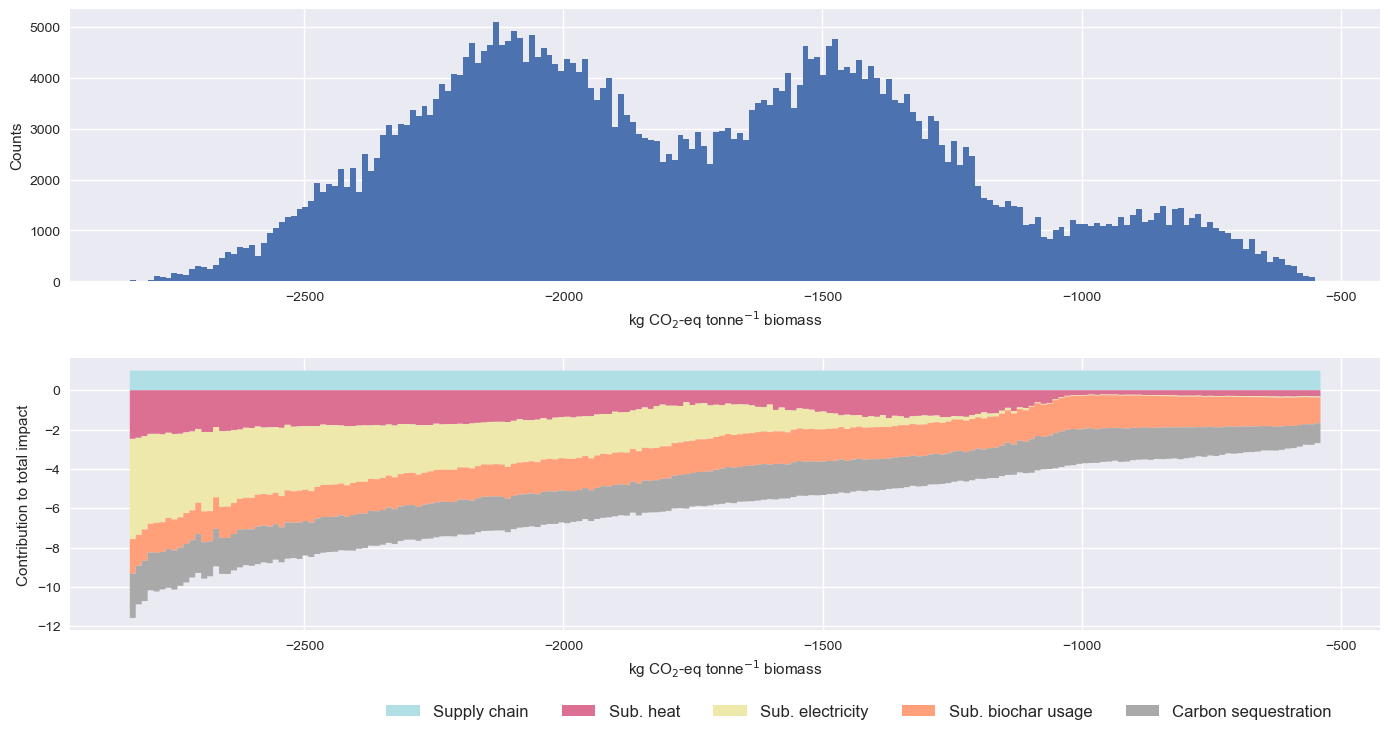

In [17]:
fig, ax = plt.subplots(ncols=1,nrows=2, figsize=(14,7))
ax_line = ax.ravel() # ax[i,j] while axl[k] where k correspond to i*col+j or something like that

df_norm = df.div(df['Supply chain'], axis=0) # normalize to make figures easier to read

df_tot = pd.DataFrame({'total':df.sum(axis=1)}) # save total score

# First graph: axl[0] or ax[0,0] > plot histogram
nb_bins = 200 # number of bins
n, bins, _ = ax_line[0].hist(df_tot, bins=nb_bins) # plot histogram 

# n contains: the values of the histogram bins
# bins contains: the edges of the bins
# cf: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html

# apply the bins to the df_tot, either : pd.cut (equal-width) or pd.qcut (equal-size)
df_tot['binned'], tmp = pd.cut(df_tot['total'], bins=nb_bins, labels=False, retbins=True)
# pd.cut should give the same distribution as the hist

# we add these bins to the df with normalised contrib
df_norm['binned'] = df_tot['binned']
# pandas average based on column value
df_norm_grouped = df_norm.groupby('binned', as_index=True).mean() # as_index = True implies 'binned' is the index of the new df
df_norm_grouped

bins_continuous = np.zeros(0)
df_norm_grouped_continuous = pd.DataFrame({})
reps = 100

for i in range(len(bins)-1):
    bins_continuous = np.concatenate( (bins_continuous, np.linspace(bins[i], bins[i+1], reps, endpoint=False)) )

    for col in df_norm_grouped.columns:
        df_norm_grouped_continuous[col] = df_norm_grouped[col].repeat(reps)

for i in range(len(bins)-1):
    if i not in df_norm_grouped.index:
        salsa = pd.DataFrame(np.zeros((reps,len(df_norm_grouped_continuous.columns))),
                             index=[i]*100,
                             columns=df_norm_grouped_continuous.columns)
        df_norm_grouped_continuous = df_norm_grouped_continuous.append(salsa)

df_norm_grouped_continuous.sort_index(inplace=True)

# split neg & pos values
df_norm_grouped_continuous_pos = df_norm_grouped_continuous[df_norm_grouped_continuous >= 0].fillna(0)
df_norm_grouped_continuous_neg = df_norm_grouped_continuous[df_norm_grouped_continuous < 0].fillna(0)

# Second graph: axl[1] or ax[1,0] > plot stacked bar binned ... in fact ... stacked area works
colormap = ['powderblue', 'palevioletred', 'palegoldenrod', 'lightsalmon', 'darkgray']
ax_line[1].stackplot(bins_continuous, 
                     [df_norm_grouped_continuous_pos.loc[:, col] for col in df_norm_grouped_continuous_pos.columns],
                     labels=df_norm_grouped_continuous_pos.columns,
                    colors=colormap)

ax_line[1].stackplot(bins_continuous, 
                     [df_norm_grouped_continuous_neg.loc[:, col] for col in df_norm_grouped_continuous_neg.columns],
                    colors=colormap)

# Some axies titles
ax_line[0].set_xlabel('kg CO$_2$-eq tonne$^{-1}$ biomass')
ax_line[0].set_ylabel('Counts')

ax_line[1].set_xlabel('kg CO$_2$-eq tonne$^{-1}$ biomass')
ax_line[1].set_ylabel('Contribution to total impact')

# legend outside the box
handles, labels = ax_line[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='right', ncol=5,fontsize=12,
                    borderaxespad=-0.8, bbox_to_anchor=(0.95, -0.0250))

fig.tight_layout(h_pad=2, w_pad=3)


In [15]:
# save figure
fig.savefig('CA_distrib.png', dpi=1000, bbox_inches='tight')